# Deep Gaussian Processes

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import math

# Generate toy sinusoid dataset
def generate_sinusoid_data(n_points=1000):
    X = torch.linspace(0, 2 * math.pi, n_points, dtype=torch.float64).unsqueeze(1)
    y = torch.sin(X).squeeze() + 0.1 * torch.randn(X.size(0))
    return X, y


X, y = generate_sinusoid_data()

train_n = int(math.floor(0.8 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()


In [2]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
from gp.deepgp import BotorchDeepGP
import gpytorch
from gpytorch.mlls.variational_elbo import VariationalELBO

# Initialize the model
train_x_shape = train_x.shape
model = BotorchDeepGP(train_x_shape)
likelihood = model.likelihood

if torch.cuda.is_available():
    model = model.cuda()

In [4]:
import tqdm
from gpytorch.mlls import DeepApproximateMLL

# Set training mode
model.train()
likelihood.train()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the loss function
mll = DeepApproximateMLL(VariationalELBO(likelihood, model, num_data=train_x.size(0)))

num_epochs = 15
num_samples = 10

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        with gpytorch.settings.num_likelihood_samples(num_samples):
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()

            minibatch_iter.set_postfix(loss=loss.item())

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

In [5]:
# Evaluate the model
model.eval()

# Predict for the training set
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=False)
train_predictive_means, train_predictive_variances, _ = model.predict(train_loader)

# Predict for the test set
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
test_predictive_means, test_predictive_variances, test_lls = model.predict(test_loader)

rmse = torch.mean(torch.pow(test_predictive_means.mean(0) - test_y, 2)).sqrt()
print(f"RMSE: {rmse.item()}, NLL: {-test_lls.mean().item()}")


RMSE: 0.4675706883212304, NLL: 2.323167763729485


In [6]:
print(test_predictive_means.shape)
print(model.posterior(test_x).mean.shape)

torch.Size([10, 200])
torch.Size([200, 1])


tensor([[ 6.0046e-02,  1.8058e-02,  8.9472e-02,  ..., -1.0645e+00,
         -1.0712e+00, -1.0953e+00],
        [ 1.0684e-01, -1.6500e-02,  1.9341e-03,  ..., -1.0883e+00,
         -1.0806e+00, -1.0519e+00],
        [ 1.1659e-02,  3.9881e-02, -3.1873e-05,  ..., -1.0905e+00,
         -1.0333e+00, -1.0164e+00],
        ...,
        [ 4.7796e-02,  4.3203e-02,  3.2810e-02,  ..., -1.0481e+00,
         -1.0886e+00, -1.0669e+00],
        [ 9.3263e-02,  3.7426e-02,  7.7507e-02,  ..., -1.0609e+00,
         -1.0861e+00, -1.0455e+00],
        [ 9.0265e-02,  1.0765e-01,  6.4996e-02,  ..., -1.0746e+00,
         -1.0424e+00, -1.0698e+00]], device='cuda:0', dtype=torch.float64)


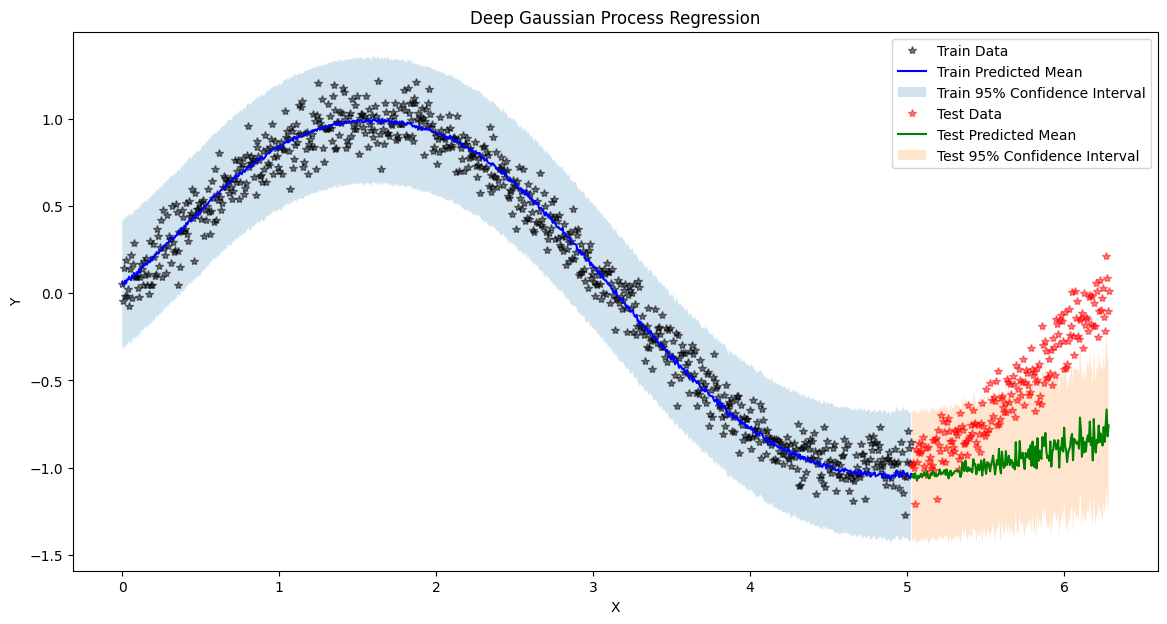

In [7]:
from matplotlib import pyplot as plt

# Convert tensors to numpy for plotting
train_predictive_means2 = train_predictive_means.mean(0).cpu().detach().numpy()
train_predictive_variances2 = train_predictive_variances.mean(0).cpu().detach().numpy()
test_predictive_means2 = test_predictive_means.mean(0).cpu().detach().numpy()
test_predictive_variances2 = test_predictive_variances.mean(0).cpu().detach().numpy()

print(train_predictive_means)

train_x_np = train_x.cpu().detach().numpy()
train_y_np = train_y.cpu().detach().numpy()
test_x_np = test_x.cpu().detach().numpy()
test_y_np = test_y.cpu().detach().numpy()

# Calculate confidence intervals for train and test sets
train_lower = train_predictive_means2 - 2 * np.sqrt(train_predictive_variances2)
train_upper = train_predictive_means2 + 2 * np.sqrt(train_predictive_variances2)
test_lower = test_predictive_means2 - 2 * np.sqrt(test_predictive_variances2)
test_upper = test_predictive_means2 + 2 * np.sqrt(test_predictive_variances2)

# Plot the results
plt.figure(figsize=(14, 7))

# Training data
plt.plot(train_x_np, train_y_np, 'k*', alpha=0.5, label='Train Data')
plt.plot(train_x_np, train_predictive_means2, 'b', label='Train Predicted Mean')
plt.fill_between(train_x_np.squeeze(), train_lower, train_upper, alpha=0.2, label='Train 95% Confidence Interval')

# Test data
plt.plot(test_x_np, test_y_np, 'r*', alpha=0.5, label='Test Data')
plt.plot(test_x_np, test_predictive_means2, 'g', label='Test Predicted Mean')
plt.fill_between(test_x_np.squeeze(), test_lower, test_upper, alpha=0.2, label='Test 95% Confidence Interval')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Deep Gaussian Process Regression')
plt.show()


In [8]:
from gp.variationalgp import MixedSingleTaskVariationalGP

# botorch_variational_gp = SingleTaskVariationalGP(train_x, train_y.unsqueeze(1), inducing_points=128)
# train_adj_ypre = train_y.unsqueeze(1)
train_adj_x = torch.cat((train_x, torch.zeros(train_x.size(0), 1, device='cuda')), dim=1)
# train_adj_y = torch.cat((train_adj_ypre, torch.zeros(train_adj_ypre.size(0), 1, device='cuda')), dim=1)
train_adj_y = train_y.unsqueeze(1)

test_adj_x = torch.cat((test_x, torch.zeros(test_x.size(0), 1, device='cuda')), dim=1)
test_adj_y = test_y.unsqueeze(1)
# test_adj_ypre = test_y.unsqueeze(1)
# test_adj_y = torch.cat((test_adj_ypre, torch.zeros(test_adj_ypre.size(0), 1, device='cuda')), dim=1)

print(train_y.shape)
print(train_adj_x.shape)
print(train_adj_y.shape)

train_adj_dataset = TensorDataset(train_adj_x, train_y)
test_adj_dataset = TensorDataset(test_adj_x, test_y)

torch.Size([800])
torch.Size([800, 2])
torch.Size([800, 1])


In [13]:
from gp.mixeddeepgp import BotorchDeepGPMixed
from gp.deepgp import BotorchDeepGP
import gpytorch
from gpytorch.mlls.variational_elbo import VariationalELBO

# Initialize the model
train_x_shape = train_adj_x.shape
model_mixed = BotorchDeepGPMixed(train_x_shape, [1])
# likelihood = model.likelihood

if torch.cuda.is_available():
    model_mixed = model_mixed.cuda()

In [14]:
import tqdm
from gpytorch.mlls import DeepApproximateMLL

# Set training mode
model_mixed.train()
# likelihood.train()

# Define the optimizer
optimizer = torch.optim.Adam(model_mixed.parameters(), lr=0.01)

# Define the loss function
mll = DeepApproximateMLL(VariationalELBO(model_mixed.likelihood, model_mixed, num_data=train_x.size(0)))

num_epochs = 15
num_samples = 10

train_adj_loader = DataLoader(train_adj_dataset, batch_size=32)

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_adj_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        with gpytorch.settings.num_likelihood_samples(num_samples):
            optimizer.zero_grad()
            output = model_mixed(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()

            minibatch_iter.set_postfix(loss=loss.item())
            

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/25 [00:00<?, ?it/s]

RMSE: 0.4487935025721148, NLL: 0.8160051844650704
torch.Size([10, 200])
torch.Size([200, 1])
tensor([[ 0.5451,  0.6403,  0.6143,  ..., -0.9554, -0.9169, -0.9142],
        [ 0.6180,  0.6359,  0.6492,  ..., -0.9129, -0.8421, -0.9032],
        [ 0.7164,  0.5728,  0.6198,  ..., -0.9526, -0.9377, -0.9152],
        ...,
        [ 0.5634,  0.5681,  0.6768,  ..., -0.9134, -0.8903, -0.8897],
        [ 0.6945,  0.6587,  0.5340,  ..., -0.9353, -0.9464, -0.8767],
        [ 0.6102,  0.5519,  0.5145,  ..., -0.8026, -0.9137, -0.9246]],
       device='cuda:0', dtype=torch.float64)


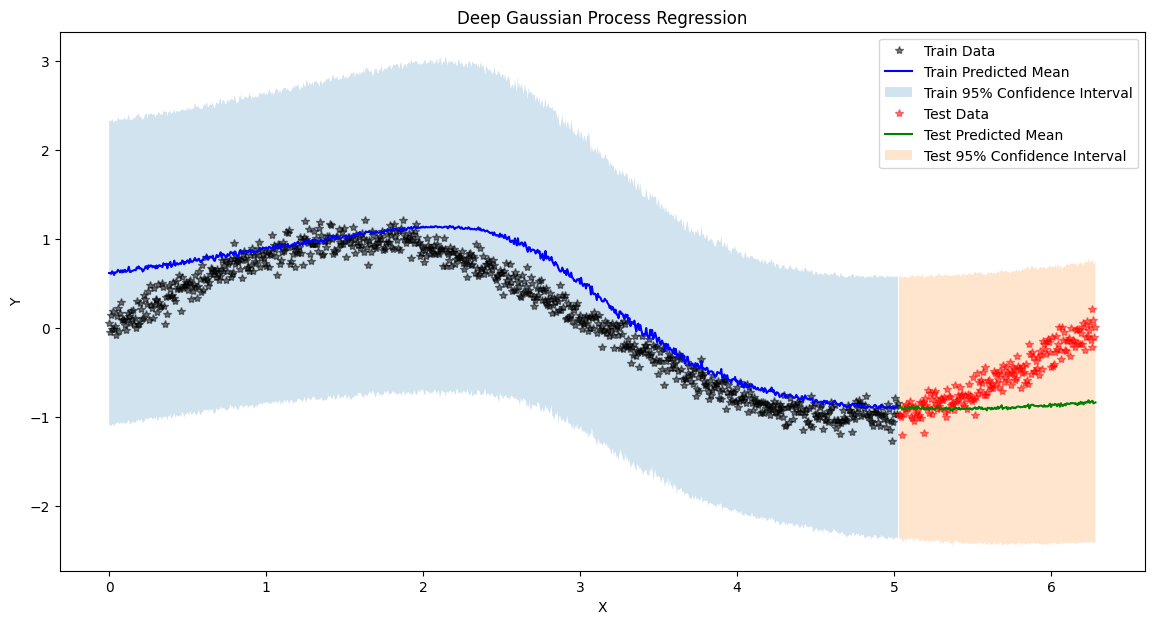

In [15]:

model.eval()

# Predict for the training set
train_adj_loader = DataLoader(train_adj_dataset, batch_size=1024, shuffle=False)
train_predictive_means, train_predictive_variances, _ = model.predict(train_adj_loader)

# Predict for the test set
test_adj_loader = DataLoader(test_adj_dataset, batch_size=1024, shuffle=False)
test_predictive_means, test_predictive_variances, test_lls = model.predict(test_adj_loader)

rmse = torch.mean(torch.pow(test_predictive_means.mean(0) - test_y, 2)).sqrt()
print(f"RMSE: {rmse.item()}, NLL: {-test_lls.mean().item()}")

print(test_predictive_means.shape)
print(model.posterior(test_adj_x).mean.shape)
from matplotlib import pyplot as plt

# Convert tensors to numpy for plotting
train_predictive_means2 = train_predictive_means.mean(0).cpu().detach().numpy()
train_predictive_variances2 = train_predictive_variances.mean(0).cpu().detach().numpy()
test_predictive_means2 = test_predictive_means.mean(0).cpu().detach().numpy()
test_predictive_variances2 = test_predictive_variances.mean(0).cpu().detach().numpy()

print(train_predictive_means)

train_x_np = train_x.cpu().detach().numpy()
train_y_np = train_y.cpu().detach().numpy()
test_x_np = test_x.cpu().detach().numpy()
test_y_np = test_y.cpu().detach().numpy()

# Calculate confidence intervals for train and test sets
train_lower = train_predictive_means2 - 2 * np.sqrt(train_predictive_variances2)
train_upper = train_predictive_means2 + 2 * np.sqrt(train_predictive_variances2)
test_lower = test_predictive_means2 - 2 * np.sqrt(test_predictive_variances2)
test_upper = test_predictive_means2 + 2 * np.sqrt(test_predictive_variances2)

# Plot the results
plt.figure(figsize=(14, 7))

# Training data
plt.plot(train_x_np, train_y_np, 'k*', alpha=0.5, label='Train Data')
plt.plot(train_x_np, train_predictive_means2, 'b', label='Train Predicted Mean')
plt.fill_between(train_x_np.squeeze(), train_lower, train_upper, alpha=0.2, label='Train 95% Confidence Interval')

# Test data
plt.plot(test_x_np, test_y_np, 'r*', alpha=0.5, label='Test Data')
plt.plot(test_x_np, test_predictive_means2, 'g', label='Test Predicted Mean')
plt.fill_between(test_x_np.squeeze(), test_lower, test_upper, alpha=0.2, label='Test 95% Confidence Interval')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Deep Gaussian Process Regression')
plt.show()